# Shuffle and learn

Train encoder to predict if 3 frames are in correct temporal order or not.  
Paper: https://arxiv.org/abs/1603.08561

In [1]:
import cv2

import sys

sys.path.append('/scratch/mz2476/DL/project/')

import os
import random

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200
from ssl_project.data_loaders import plot_utils

import imageio

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from ssl_project.data_loaders.data_helper import UnlabeledDataset, LabeledDataset
from ssl_project.data_loaders.helper import collate_fn, draw_box
from ssl_project import constants

from ssl_project.preprocessing import top_down_segmentation


from ssl_project.utils import to_np

In [2]:
from ssl_project.constants import *
from ssl_project.paths import *

In [3]:
from logger_hparams import HyperparamsSummaryTensorBoardLogger

from ssl_project.ssl_ideas.preprocessing import TripleDataset
from ssl_project.ssl_ideas.model import SET_SEED, ShuffleAndLearnModel

In [4]:
import pytorch_lightning as pl 

In [5]:
import multiprocessing

multiprocessing.cpu_count()

28

In [6]:
from joblib import Parallel, delayed
from time import sleep

In [7]:
# %%time
# Parallel(n_jobs=20)(delayed(sleep)(1) for _ in range(32))

# Train model

In [7]:
SET_SEED()

In [8]:
from argparse import Namespace

In [10]:
LOGS_DIR   = "lightning_logs"
hparams = Namespace(
    fit_all_encoders=False,
    lr=3e-3,
    num_workers=16,
    batch_size=64,
)

MODEL_NAME = f"first_try_many_encoders={hparams.fit_all_encoders}"
version = "02"

In [11]:
logger = HyperparamsSummaryTensorBoardLogger(LOGS_DIR, name=MODEL_NAME, version=version)
model  = ShuffleAndLearnModel(hparams=hparams)

In [12]:
trainer = pl.Trainer(
    gpus=1, 
#     auto_lr_find=True,
    show_progress_bar=True,
    val_check_interval=0.25,
#     train_percent_check=0.001,
#     val_percent_check=0.01,
    logger=logger,
    precision=32,
)

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


In [13]:
trainer.fit(model, )

INFO:lightning:Set SLURM handle signals.
INFO:lightning:
   | Name                                                 | Type               | Params
----------------------------------------------------------------------------------------
0  | model                                                | ShuffleAndLearnNet | 18 M  
1  | model.resnet_encoder                                 | encoder            | 11 M  
2  | model.resnet_encoder.resnet_encoder                  | Sequential         | 11 M  
3  | model.resnet_encoder.resnet_encoder.0                | Conv2d             | 9 K   
4  | model.resnet_encoder.resnet_encoder.1                | BatchNorm2d        | 128   
5  | model.resnet_encoder.resnet_encoder.2                | ReLU               | 0     
6  | model.resnet_encoder.resnet_encoder.3                | MaxPool2d          | 0     
7  | model.resnet_encoder.resnet_encoder.4                | Sequential         | 147 K 
8  | model.resnet_encoder.resnet_encoder.4.0              | Ba

INFO:lightning:Detected KeyboardInterrupt, attempting graceful shutdown...


1

In [15]:
ls

cam_front_full/        __pycache__/
final_checkpoint.ckpt  shuffle_and_learn.ipynb
lightning_logs/        shuffle_and_learn_SINGLE_ENCODER.ipynb
logger_hparams.py      tb_logs/
model.py               trash.ipynb
preprocessing.py


In [16]:
trainer.save_checkpoint("lightning_logs/first_try_many_encoders=False/version_01/checkpoints/final_checkpoint.ckpt")

In [18]:
new_model = ShuffleAndLearnModel.load_from_checkpoint(checkpoint_path="lightning_logs/first_try_many_encoders=False/version_01/checkpoints/final_checkpoint.ckpt")

In [22]:
dataset = TripleDataset(scene_ids=[1,2])

In [26]:
from torch.utils.data import DataLoader

In [36]:
next(iter(new_model.val_dataloader()))

[tensor([[[[[0.2431, 0.2588, 0.2784,  ..., 0.0745, 0.0510, 0.0549],
            [0.2353, 0.2039, 0.1882,  ..., 0.0745, 0.0706, 0.0706],
            [0.2706, 0.2235, 0.1882,  ..., 0.0784, 0.0745, 0.0745],
            ...,
            [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
            [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
            [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
           [[0.2706, 0.3020, 0.3412,  ..., 0.0745, 0.0510, 0.0549],
            [0.2588, 0.2431, 0.2510,  ..., 0.0745, 0.0706, 0.0706],
            [0.2902, 0.2627, 0.2392,  ..., 0.0784, 0.0745, 0.0745],
            ...,
            [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
            [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
            [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
           [[0.1490, 0.2471, 0.3922,  ..., 0.0745, 0.0431, 0.0471],
            [0.1569, 0.2000, 0.3020,  ..., 0.0745, 0.0627, 0.0627],
        

In [52]:
val_dataset = new_model.val_dataloader().dataset

In [56]:
ls ..

constants.py        model_loader_utils.py*  road_layout_prediction/
data/               models/                 ssl_ideas/
data_loaders/       notebooks/              submission/
deprecated/         paths.py                tests/
encoder.py          preprocessing/          trash_1.ipynb
fastai_trash.ipynb  __pycache__/            trash.ipynb
__init__.py         pytest.ini              trash_nvidia.ipynb
labeled_images.csv  README.md               utils.py
model_loader.py     report/                 vehicle_layout_prediction/


In [57]:
from ssl_project.data_loaders import plot_utils

In [59]:
one_sample = val_dataset[0]

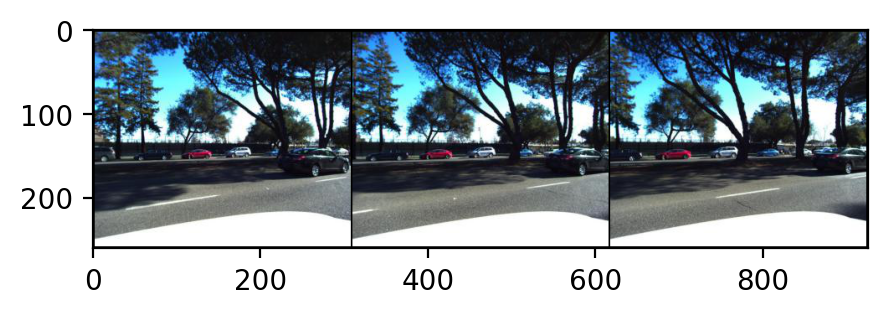

In [58]:
plot_utils.plot_photos(val_dataset[0][0])

In [39]:
fcast = new_model(image, cam_names)

In [40]:
fcast

tensor([[ 1.8633e-02, -7.5253e+00],
        [-8.6032e-02, -1.5705e+01],
        [-5.6647e-02, -5.3693e+00],
        [-4.9541e-02, -1.7617e+01],
        [-3.7489e-02, -1.2271e+01],
        [-1.0113e-01, -2.0125e+01],
        [ 2.0417e-02, -1.6076e+00],
        [ 2.3431e-02, -1.1909e+01],
        [-8.4780e-02,  3.2566e+00],
        [-7.8819e-02, -4.1785e+00],
        [-4.4860e-02,  6.3046e-01],
        [ 3.7219e-03, -2.3705e+00],
        [-5.0511e-02, -7.5695e+00],
        [-9.8414e-02, -1.4011e+01],
        [-2.4096e-01, -1.4850e+01],
        [-3.0351e-02, -1.5311e+00],
        [ 1.0798e-01, -9.5816e+00],
        [-1.3109e-01, -1.3247e+01],
        [-7.5002e-02, -1.1942e+01],
        [-4.4233e-02, -5.2272e+00],
        [-9.9425e-02, -4.9105e+00],
        [ 3.1308e-02, -4.2955e+00],
        [-1.6358e-01, -1.4002e+01],
        [-7.3796e-02, -7.0868e+00],
        [ 3.2164e-02, -9.4889e+00],
        [-8.2731e-02, -7.9041e+00],
        [ 7.0664e-02, -1.1651e+01],
        [ 5.1001e-02, -1.514

In [41]:
target

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [42]:
from ssl_project.utils import to_np

In [45]:
fcast = to_np(fcast)

In [46]:
prob = np.exp(fcast[:, 1]) / (np.exp(fcast[:, 1]) + np.exp(fcast[:, 0]))

(array([32.,  2.,  3.,  2.,  0.,  1.,  2.,  1.,  1., 20.]),
 array([2.0119717e-09, 9.9999160e-02, 1.9999832e-01, 2.9999748e-01,
        3.9999664e-01, 4.9999580e-01, 5.9999496e-01, 6.9999415e-01,
        7.9999328e-01, 8.9999247e-01, 9.9999160e-01], dtype=float32),
 <a list of 10 Patch objects>)

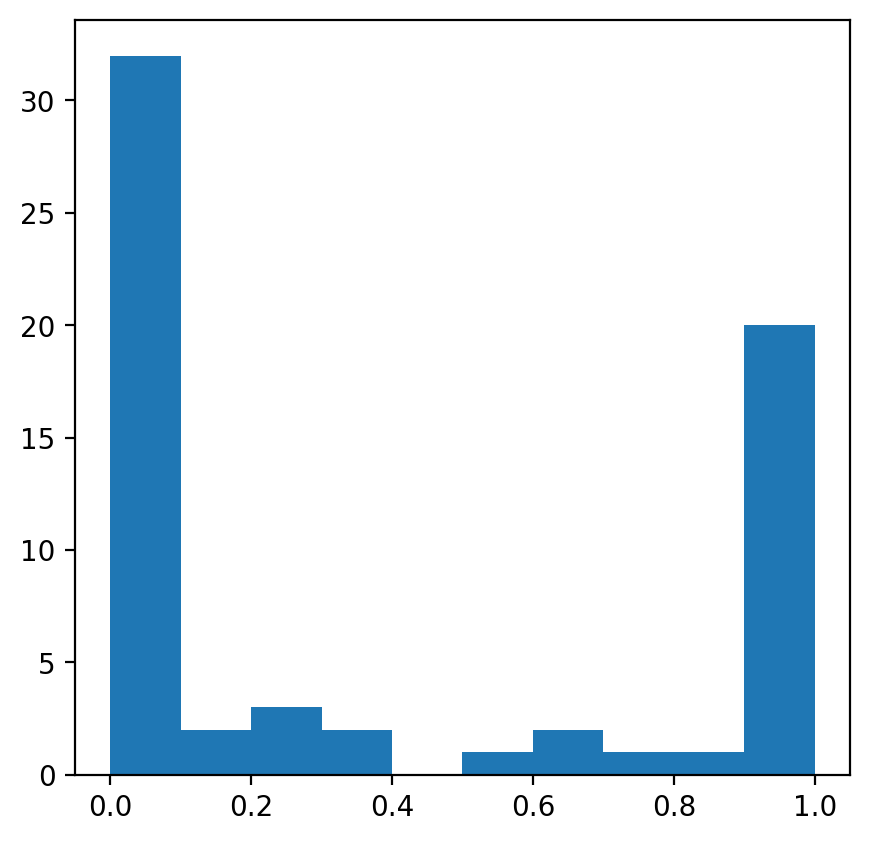

In [49]:
plt.hist(prob)

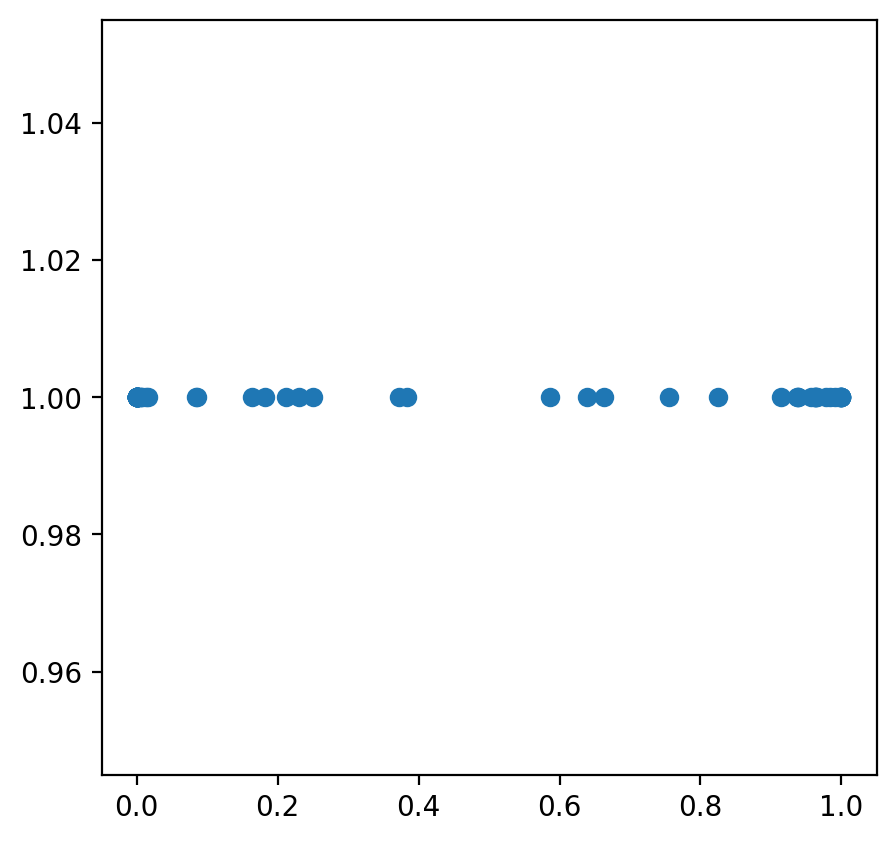

In [47]:

plt.scatter(prob, to_np(target))